# Quick hands-on introduction to xarray, with help from GDAL

Xarray brings the power of pandas-style data frames to gridded data sets. This notebook provides a few examples of using xarray to store and manipulate grids of topography and related data such as slope gradient and aspect. In order to read a topography data set and generate some derived grids, we'll use the GDAL geospatial library.

(Greg Tucker, University of Colorado, for Computational Tools class, Oct 2018)

## Part 1: Using GDAL to read a digital elevation model and generate some additional grids

### Getting the DEM

First, some imports:

In [7]:
import numpy as np
import xarray as xr
from osgeo import gdal
from matplotlib import pyplot as plt
%matplotlib inline

This example uses a lidar-derived digital elevation model (DEM) of a portion of the Boulder Creek Critical Zone Observtory in the Colorado Front Range.

Navigate a browser to http://criticalzone.org/boulder/data/dataset/2915/ 

Select Betasso (Snow off - filtered) - 1m Filtered DSM

Save the zip file, and double-click to unzip it. Inside the folder ``img`` you will see a file called ``czo_1m_bt1.img``. This is a 1 m resolution lidar-derived DEM of a stretch of Boulder Creek Canyon, with the small Betasso tributary catchment located roughly in the center.

We'll set a variable to identify the relative path name to the file. The default line below assumes the folder ``img`` is in your current working directory; change it if needed.

In [8]:
betasso_dem_name = 'img/czo_1m_bt1.img'

The following code uses the GDAL function ``Open`` to open and read the contents of the file into a variable ``geo``, and then assign the gridded elevation data to a numpy array called ``zb``. Later on, we'll want the coordinates of the lower left corner of the DEM, so we call the ``GetGeoTransform()``. This function provides (among other things) the coordinates of the upper-left corner. For completeness, the example here shows how to obtain the lower right corner. From these, we find the x coordinate of the left side and the y coordinate of the bottom, which we'll use shortly.

In [9]:
geo = gdal.Open(betasso_dem_name)
zb = geo.ReadAsArray()
ulx, xres, xskew, uly, yskew, yres  = geo.GetGeoTransform()
print((ulx, xres, xskew, uly, yskew, yres))
lrx = ulx + (geo.RasterXSize * xres)
lry = uly + (geo.RasterYSize * yres)
left_x = ulx
bottom_y = lry
print((left_x, bottom_y))

(468838.50000000093, 1.0, 0.0, 4430486.5, 0.0, -1.0)
(468838.50000000093, 4427754.5)


As is typical of a DEM, there are some cells whose values are undefined. These are indicated by a "no data" value, in this case a large negative value. Because these cells can complicate plotting and analysis, we will identify the lowest valid elevation in the grid, and then assign it to the no-data cells.

This isn't necessarily an ideal solution. An alternative would be to assign these as "nan" (not a number). But that can cause its own set of problems, so for now we'll stick with this workaround.

In [10]:
zb_min = np.amin(zb[np.where(zb>0.0)[0],np.where(zb>0.0)[1]])
print('Minimum elevation is ' + str(zb_min))
zb[np.where(zb<0.0)[0],np.where(zb<0.0)[1]] = zb_min

Minimum elevation is 1708.5753


Let's look at our DEM:

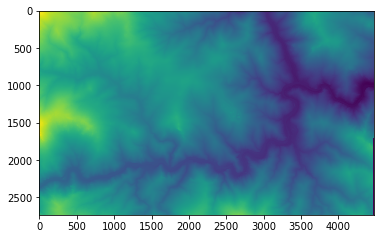

In [11]:
plt.imshow(zb)

### Generating some derived grids: slope, aspect, and hillshade

We'll define a little function to calculate slope gradient from a given 2D elevation array:

In [12]:
def slope_gradient(z):
    """Calculate absolute slope gradient elevation array.
    
    Parameters
    ----------
    z : ndarray (2D)
        Array of elevation values
    
    Returns
    -------
    ndarray (2D) : array of gradient values of the same dimensions
    """
    x, y = np.gradient(z)
    slope = np.sqrt(x*x + y*y)
    return slope

Apply our function to make a slope grid:

In [13]:
sb = slope_gradient(zb)

Plot the result (and calculate the median gradient while we're at it):

0.43659556


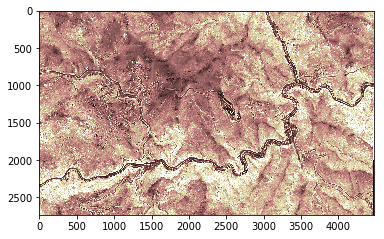

In [14]:
plt.imshow(sb, vmin=0.0, vmax=1.0, cmap='pink')
print(np.median(sb))

Now let's do the same thing for aspect:

In [15]:
def aspect(z):
    """Calculate aspect from DEM."""
    x, y = np.gradient(z)
    return np.arctan2(-x, y)

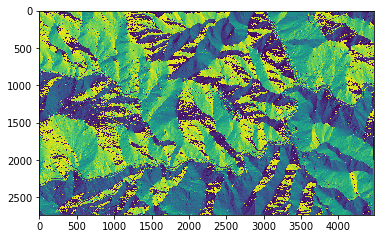

In [16]:
ab = aspect(zb)
plt.imshow(ab)

We can look at the histogram of aspect values:

Text(0,0.5,'Relative frequency')

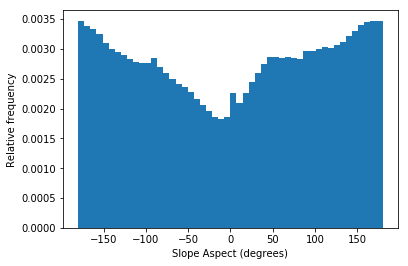

In [17]:
abdeg = (180./np.pi)*ab # convert to degrees
n, bins, patches = plt.hist(abdeg.flatten(), 50, density=True)
plt.xlabel('Slope Aspect (degrees)')
plt.ylabel('Relative frequency')

Finally, a hillshade. Start with a (borrowed) function, then apply it and plot the result.

In [18]:
def hillshade(z, azimuth=315.0, angle_altitude=45.0):
    """Generate a hillshade image from DEM.

    Notes: adapted from example on GeoExamples blog,
    published March 24, 2014, by Roger Veciana i Rovira.
    """
    x, y = np.gradient(z)
    slope = np.pi/2. - np.arctan(np.sqrt(x*x + y*y))
    aspect = np.arctan2(-x, y)
    azimuthrad = azimuth*np.pi / 180.
    altituderad = angle_altitude*np.pi / 180.
    shaded = (np.sin(altituderad) * np.sin(slope)
              + np.cos(altituderad) * np.cos(slope)
                * np.cos(azimuthrad - aspect))
    return 255*(shaded + 1)/2

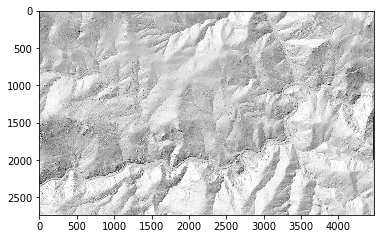

In [19]:
hb = hillshade(zb)
plt.imshow(hb, cmap='gray')

## Managing the gridded data with xarray

### Managing one grid in a DataArray

We're going to create a ``DataArray`` to store our elevation grid along with information about its coordinate values. To do this, we'll create two 1D numpy arrays to represent the east-west coordinates and north-south coordinates, respectively.

The DataArray takes as arguments: the gridded data as a numpy array (``zb``), labels for its two dimensions, and arrays to indicate values that accompany each of the two axes.

(Note that ``dist_north`` has decreasing values; this is because the first pixel is actually the top left---northwest---rather than bottom left.)

In [20]:
dist_north = np.arange(zb.shape[0] - 1, -1, -1) + bottom_y
dist_east = np.arange(zb.shape[1]) + left_x
elev_da = xr.DataArray(zb, dims=['y', 'x'],
                       coords={'y' : dist_north,
                               'x' : dist_east})
elev_da

<xarray.DataArray (y: 2732, x: 4479)>
array([[1708.5753, 1708.5753, 1708.5753, ..., 1708.5753, 1708.5753, 1708.5753],
       [1708.5753, 1708.5753, 1708.5753, ..., 1856.2356, 1856.4791, 1708.5753],
       [1708.5753, 1708.5753, 1708.5753, ..., 1856.8969, 1857.0038, 1708.5753],
       ...,
       [1708.5753, 1708.5753, 1708.5753, ..., 1708.5753, 1708.5753, 1708.5753],
       [1708.5753, 1708.5753, 1708.5753, ..., 1708.5753, 1708.5753, 1708.5753],
       [1708.5753, 1708.5753, 1708.5753, ..., 1708.5753, 1708.5753, 1708.5753]],
      dtype=float32)
Coordinates:
  * y        (y) float64 4.43e+06 4.43e+06 4.43e+06 ... 4.428e+06 4.428e+06
  * x        (x) float64 4.688e+05 4.688e+05 4.688e+05 ... 4.733e+05 4.733e+05

``DataArray`` has a built-in plot function:

(468838.00000000093, 473317.00000000093, 4427754.0, 4430486.0)

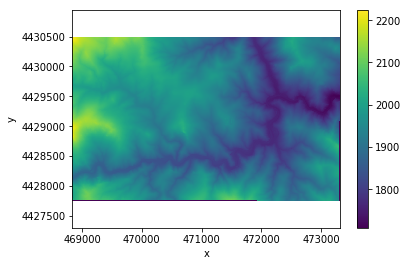

In [21]:
elev_da.plot()
plt.axis('equal')

Notice that the plot above shows the actual geographic coordinates associated with the grid values, rather than simply the array indices.

We can add information about the units of our data, and give the data a standard name (here from the CSDMS Standard Names). These attributes live in the ``DataArray``'s ``attrs`` property:

In [22]:
elev_da.attrs['units'] = 'm'
elev_da.attrs['standard_name'] = 'topographic__elevation'
elev_da

<xarray.DataArray (y: 2732, x: 4479)>
array([[1708.5753, 1708.5753, 1708.5753, ..., 1708.5753, 1708.5753, 1708.5753],
       [1708.5753, 1708.5753, 1708.5753, ..., 1856.2356, 1856.4791, 1708.5753],
       [1708.5753, 1708.5753, 1708.5753, ..., 1856.8969, 1857.0038, 1708.5753],
       ...,
       [1708.5753, 1708.5753, 1708.5753, ..., 1708.5753, 1708.5753, 1708.5753],
       [1708.5753, 1708.5753, 1708.5753, ..., 1708.5753, 1708.5753, 1708.5753],
       [1708.5753, 1708.5753, 1708.5753, ..., 1708.5753, 1708.5753, 1708.5753]],
      dtype=float32)
Coordinates:
  * y        (y) float64 4.43e+06 4.43e+06 4.43e+06 ... 4.428e+06 4.428e+06
  * x        (x) float64 4.688e+05 4.688e+05 4.688e+05 ... 4.733e+05 4.733e+05
Attributes:
    units:          m
    standard_name:  topographic__elevation

### Managing multiple grids in a *Dataset*

To create an xarray *Dataset*, we pass:

(1) a dictionary of ``data_vars`` containing, for each grid, a name for the grid as the key, and a tuple with names for its axes and the numpy array that holds the grid's data.

(2) information on the coordinates, as before.

In [23]:
betasso = xr.Dataset(
        data_vars={'elevation': (('y', 'x'), zb),
                   'slope':     (('y', 'x'), sb),
                   'aspect':    (('y', 'x'), ab),
                   'hillshade': (('y', 'x'), hb)},
        coords={'y': dist_north,
                'x': dist_east})
betasso

<xarray.Dataset>
Dimensions:    (x: 4479, y: 2732)
Coordinates:
  * y          (y) float64 4.43e+06 4.43e+06 4.43e+06 ... 4.428e+06 4.428e+06
  * x          (x) float64 4.688e+05 4.688e+05 4.688e+05 ... 4.733e+05 4.733e+05
Data variables:
    elevation  (y, x) float32 1708.5753 1708.5753 ... 1708.5753 1708.5753
    slope      (y, x) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    aspect     (y, x) float32 -0.0 -0.0 -0.0 -0.0 -0.0 ... -0.0 -0.0 -0.0 -0.0
    hillshade  (y, x) float32 217.65613 217.65613 ... 217.65613 217.65613

Individual grids can be accessed by:

``<name of Dataset>.<name of variable>``

One can access array elements and slices as with any numpy array. For example, if we want to plot an elevation profile along row 1000:

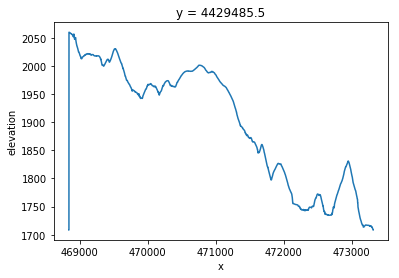

In [24]:
betasso.elevation[1000].plot()

...or a profile of aspect values along column 1000:

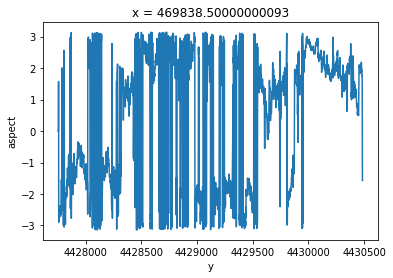

In [25]:
betasso.aspect[:, 1000].plot()

Operations with the individual numpy arrays work in the usual way. For example, convert elevation values to feet:

(468838.00000000093, 473317.00000000093, 4427754.0, 4430486.0)

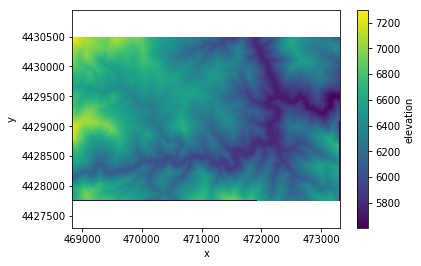

In [26]:
elev_ft = betasso.elevation / 0.3048
elev_ft.plot()
plt.axis('equal')

We can do averages along either grid dimension using the ``mean`` function. Here's an example of an east-west topographic profile showing, at each point, the north-south average elevation in the elevation grid. Notice that the result of applying ``mean`` is a new Dataset.

In [27]:
betasso_NS_mean = betasso.mean('y')
betasso_NS_mean

<xarray.Dataset>
Dimensions:    (x: 4479)
Coordinates:
  * x          (x) float64 4.688e+05 4.688e+05 4.688e+05 ... 4.733e+05 4.733e+05
Data variables:
    elevation  (x) float32 1714.9885 1769.1099 1856.08 ... 1725.4385 1708.543
    slope      (x) float32 54.321342 70.719246 86.46259 ... 17.632515 16.895882
    aspect     (x) float32 -0.036379214 -0.037264854 ... -0.5237629 -0.26103315
    hillshade  (x) float32 211.97781 206.47726 205.87065 ... 188.4037 204.904

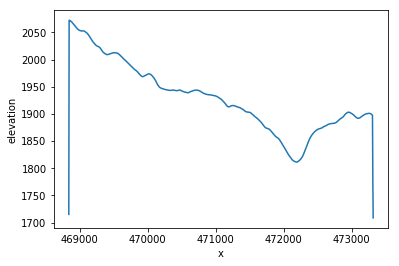

In [28]:
betasso_NS_mean.elevation.plot()

After all that hard work, it's useful to be able to store our Dataset in a file for later use, or access by another application:

In [29]:
betasso.to_netcdf('betasso_lidar_topo.nc')

*fin*.